identify domains in 3-component system using Voronoi edge method to determine neighbors and Lo/Ld; label domains and identify which lipid in each one; set min domain size
then, look for fraction of registration across leaflets
mdw 10/17/2016

In [92]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
#import scipy.cluster.hierarchy
import scipy.spatial

In [93]:
traj=md.load('../register/dbpc20_2.gro',top='../register/dbpc20_2.gro',stride=1)

In [94]:
traj.n_frames

1

In [95]:
topology=traj.topology
allhead=topology.select('name PO4 or name ROH')

In [96]:
resnames=[atom.residue.name for atom in topology.atoms]

In [97]:
#x,y coordinates of all for finding neighbors to determine local midplane z-value
# here, best to use xy radius of neighbors, since Voronoi across 2 leaflets could have complications

allheadxy=[]
allheadz=[]
##for nn in range(traj.n_frames):
##    headxy[nn]=list([] for _ in xrange(uppertotal))
for i in range(len(allhead)):
    allheadi=allhead[i]
    allheadxy.append(traj.xyz[0][allheadi][0:2:1])
    allheadz.append(traj.xyz[0][allheadi][2])


In [98]:
# mdtraj can't handle neighbors for gro (rather than xtc) inputs, so do it myself
cutoffsq = 2.4**2; #square of maximum xy distance for neighbors

neigh=list([] for _ in xrange(len(allheadxy)))


for i in range(len(allheadxy)):
    xyi=allheadxy[i]
    for j in range(len(allheadxy)-i-1): #not self, but will add for midplane finding
        xyj=allheadxy[j+i+1]
        distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
        if (distsq < cutoffsq):
            neigh[i].append(j+i+1)
            neigh[j+i+1].append(i)
        





In [99]:
#use neigh (flat) to calculate local midplane through median z-value of heads
midplane=list([] for _ in xrange(len(allheadz)))
for i in range(len(allheadz)):
    localzs=[]
    localzs.append(allheadz[i]) # include self
    for j in range(len(neigh[i])):
        localzs.append(allheadz[neigh[i][j]])
    midplane[i]=(min(localzs)+max(localzs))/2.0

In [100]:
#have array with values placing each head in one leaflet: 0=lower, 1=upper, 2=between
head_leaflet=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    head_leaflet[nn]=list([] for _ in xrange(len(allhead)))
for i in range(len(allhead)):
    if allheadz[i]<midplane[i]-0.1:
        head_leaflet[0][i]=0
    elif allheadz[i]>midplane[i]+0.1:
        head_leaflet[0][i]=1
    else:
        head_leaflet[0][i]=2
    
    

In [101]:
# only need upper leaflet heads for this situation
upperheads=[]
for i in range(len(allhead)):
    if head_leaflet[0][i]==1:
        upperheads.append(allhead[i])

In [102]:
#count DPPC as fraction of upper total, to find global concentration of DPPC
#upperdppc=list([] for _ in xrange(traj.n_frames))
#uppertotal=list([] for _ in xrange(traj.n_frames))
#globalconc=list([] for _ in xrange(traj.n_frames))

upperdppc=0
for j in range(len(upperheads)):
    if(resnames[upperheads[j]]=='DBPC' or resnames[upperheads[j]]=='CHOL'):
        upperdppc=upperdppc+1
globalconc=float(upperdppc)/len(upperheads)


In [103]:
#x,y coordinates of outer for Voronoi
#headxy=list([] for _ in xrange(traj.n_frames)) #[frame][head]
headxy=[]
##for nn in range(traj.n_frames):
##    headxy[nn]=list([] for _ in xrange(uppertotal))
for i in range(len(upperheads)):
    upperheadsi=upperheads[i]
 #   for j in range(traj.n_frames):
 #   if (head_leaflet[0][i]==1):
    headxy.append(traj.xyz[0][upperheadsi][0:2:1])


In [104]:
vor=scipy.spatial.Voronoi(np.array(headxy))
#scipy.spatial.voronoi_plot_2d(vor)


In [105]:
#Voronoi neighbors vneigh

#generate list of neighbors, edgeneigh
edgeneigh=list([] for _ in xrange(len(upperheads)))
for k in range(len(vor.ridge_points)):
    pair=vor.ridge_points[k]
    edgeneigh[pair[0]].append(pair[1])
    edgeneigh[pair[1]].append(pair[0])



vneigh=list([] for _ in xrange(len(upperheads))) #need two deep (x num frames) #lipid type
vneighres=list([] for _ in xrange(len(upperheads)))
#only frame 8, for now
for i in range(len(upperheads)):
#    upperheadi=upperheads[i]
    vneighheads=edgeneigh[i] #upperhead index, not atom
    if not vneighheads:
        vneigh[i]=[]
        vneighres[i]=[]
    else:
        for j in range(len(vneighheads)):
            vneigh[i].append(resnames[upperheads[vneighheads[j]]])
            vneighres[i].append(vneighheads[j])







In [106]:
#phase based on edges
vphase=list([] for _ in xrange(len(upperheads)))
for i in range(len(upperheads)):
    vneightot=1+len(vneigh[i]) #include self
    num_sat=0
    if (resnames[upperheads[i]]=='DBPC' or resnames[upperheads[i]]=='CHOL'):
            num_sat=num_sat+1
    for j in range(len(vneigh[i])):
        if (vneigh[i][j]=='DBPC' or vneigh[i][j]=='CHOL'):
            num_sat=num_sat+1
    vlocal_conc=float(num_sat)/vneightot #integer would always be zero
    if (vlocal_conc > globalconc):
        vphase[i] = 1 # Lo=1
    else:
        vphase[i] = 0 # Ld=0
        

In [107]:
#iterate edge-based phase determination to reduce small clusters
vphase2=list([] for _ in xrange(len(upperheads)))
for i in range(len(upperheads)):
    vneightot=1+len(vneigh[i])
    num_lo=0
    if (vphase[i]==1):
        num_lo=num_lo+1
    for j in range(len(vneigh[i])):
        if(vphase[vneighres[i][j]]==1):
            num_lo=num_lo+1
    vlocal_conc=float(num_lo)/vneightot
    if (vlocal_conc > 0.49):
        vphase2[i]=1
    else:
        vphase2[i]=0

In [108]:
#iterate edge-based phase determination to reduce small clusters
vphase3=list([] for _ in xrange(len(upperheads)))
for i in range(len(upperheads)):
    vneightot=1+len(vneigh[i])
    num_lo=0
    if (vphase2[i]==1):
        num_lo=num_lo+1
    for j in range(len(vneigh[i])):
        if(vphase2[vneighres[i][j]]==1):
            num_lo=num_lo+1
    vlocal_conc=float(num_lo)/vneightot
    if (vlocal_conc > 0.49):
        vphase3[i]=1
    else:
        vphase3[i]=0

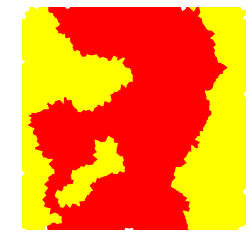

In [123]:
# color Voronoi polygons
fig,ax=plt.subplots(1)
patches=[]
cmap=plt.get_cmap('autumn')
#flatphase=[val for sublist in cphase for val in sublist]
#colors=cmap([x*10 for x in flatphase])
colors=cmap([(x*256) for x in vphase3])
#for region in range(len(vor.regions)):
#    if not -1 in vor.regions[region]:
#        pg=Polygon(vor.vertices,closed=True)
#        patches.append(pg)




for i in range(len(vor.point_region)):
    verts=vor.regions[vor.point_region[i]] #indices of vertices forming that region
    if (verts==[]):
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    elif (not -1 in verts):
        vertcoord=list([] for _ in xrange(len(verts))) #coordinates of vertices
        for j in range(len(verts)):
            k=verts[j]
            vertcoord[j]=vor.vertices[k]
        pg=Polygon(vertcoord,closed=True)
        patches.append(pg)
    else:
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    



collection=PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
        
#plt.fill(*zip(*pg))
ax.set_aspect('equal')
ax.set_xlim([0,36.5])
ax.set_ylim([0,36.5])

plt.axis('off')

#plt.savefig('50_2_phases.pdf',format='pdf')
plt.show()

In [110]:
# identify and number domains, then determine which are too small
# start with 1st lipid, call domain 1, label all neighbors in same phase as also domain 1,...
# reserve domain 0 for unassigned, so 1 is 1st domain

In [111]:
domain=list([] for _ in xrange(len(upperheads)))
for i in range(len(upperheads)):
    domain[i]=0 # 0 = unassigned

recurlist=[] # list of heads that must run through domain algorithm because in chain of neighbors
    
domain[0]=1 # first lipid sets first domain
for i in range(len(vneighres[0])): # vneighres is allheadz index, not atom
    ni=vneighres[0][i]
    if vphase3[ni]==vphase3[0]: #only neighbors in same phase
        domain[ni]=1
        recurlist.append(ni)
num_domains=1

while len(recurlist): # no new domain should be introduced in this section
    headi=recurlist[0]
    neighi=vneighres[headi]
    recurlist=recurlist[1:] # remove 1st element, now being handled
    for j in range(len(neighi)):
        ni=neighi[j]
        if (vphase3[ni]==vphase3[headi] and domain[ni]==0): #avoid infinitely putting back into recurlist
            domain[ni]=domain[headi]
            recurlist.append(ni)

#now iterate over other lipids, excluding those already marked
for i in range(len(upperheads)-1): # 0 already done
    if domain[i+1]==0: #not yet marked
        neighi=vneighres[i+1]
        num_domains=num_domains+1
        domain[i+1]=num_domains
        for j in range(len(neighi)):
            ni=neighi[j]
            if vphase3[ni]==vphase3[i+1]:
                domain[ni]=domain[i+1] 
                recurlist.append(ni)
        while len(recurlist): #until exhausted, then move onto next new domain
            headi=recurlist[0]
            neighi=vneighres[headi]
            recurlist=recurlist[1:]
            for j in range(len(neighi)):
                ni=neighi[j]
                if (vphase3[ni]==vphase3[headi] and domain[ni]==0):
                    domain[ni]=domain[headi]
                    recurlist.append(ni)
        
    
    


In [112]:
max(domain)

4

In [72]:
vneighres[-1]

[84, 2222, 2221, 334, 1351]

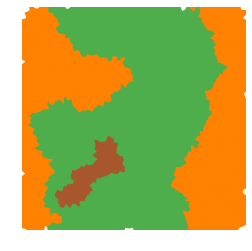

In [128]:
# color Voronoi polygons by domain number
fig,ax=plt.subplots(1)
patches=[]
cmap=plt.get_cmap('Set1')
#flatphase=[val for sublist in cphase for val in sublist]
#colors=cmap([x*10 for x in flatphase])
colors=cmap([x/4. for x in domain_adjusted])
#for region in range(len(vor.regions)):
#    if not -1 in vor.regions[region]:
#        pg=Polygon(vor.vertices,closed=True)
#        patches.append(pg)




for i in range(len(vor.point_region)):
    verts=vor.regions[vor.point_region[i]] #indices of vertices forming that region
    if (verts==[]):
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    elif (not -1 in verts):
        vertcoord=list([] for _ in xrange(len(verts))) #coordinates of vertices
        for j in range(len(verts)):
            k=verts[j]
            vertcoord[j]=vor.vertices[k]
        pg=Polygon(vertcoord,closed=True)
        patches.append(pg)
    else:
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    



collection=PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
        
#plt.fill(*zip(*pg))
ax.set_aspect('equal')
ax.set_xlim([0,36.5])
ax.set_ylim([0,36.5])

plt.axis('off')

#plt.savefig('dpbc20_2_domains_adjust_pbc&size.pdf',format='pdf')
plt.show()

In [121]:
domain_test=list([] for _ in xrange(len(domain)))
for i in range(len(domain_test)):
    if domain[i]==4:
        domain_test[i]=1.0
    else:
        domain_test[i]=0.0

In [38]:
# how to fix non-recognition across periodic boundary?
## manually, for now; 6 is part of 2; 4&5 are part of 1
# 3, 4 part of 2
domain_adjusted=list([] for _ in xrange(len(domain)))
for i in range(len(domain_adjusted)):
    if (domain[i]==3):# ==6):
        domain_adjusted[i]=2
#    elif (domain[i]==4 or domain[i]==5):
#        domain_adjusted[i]=1
    else:
        domain_adjusted[i]=domain[i]

In [124]:
# see how many lipids in each domain
num_domains=max(domain)
domainsize=list([] for _ in xrange(num_domains))
for i in range(len(domainsize)):
    domainsize[i]=0
for i in range(len(domain)):
    di=domain[i]-1 #return to 0-index
    domainsize[di]=domainsize[di]+1
    

In [125]:
domainsize

[1071, 653, 593, 106]

In [86]:
# see how many lipids in each domain
num_domainsadj=max(domain_adjusted)
domainsizeadj=list([] for _ in xrange(num_domainsadj))
for i in range(len(domainsizeadj)):
    domainsizeadj[i]=0
for i in range(len(domain_adjusted)):
    di=domain_adjusted[i]-1 #return to 0-index
    domainsizeadj[di]=domainsizeadj[di]+1
    

In [87]:
domainsizeadj

[1199, 1082]

In [126]:
# how to fix too-small domains?
# use domain size measurements, but must find a way to identify surrounding domain's number
# manually, for now; 6 is part of 2; 4&5 are part of 1
# 7,8,9 too small --> switch to 2 (opp phase)
# 10,11,12,13,14,15,16 --> switch to 1 (opp phase)
# 3, only 32 lipids, left alone for now
domain_adjusted=list([] for _ in xrange(len(domain)))
for i in range(len(domain_adjusted)):
    if (domain[i]==3 or domain[i]==2):
        domain_adjusted[i]=2
    elif (domain[i]==4):
        domain_adjusted[i]=3
#    elif (domain[i]==7 or domain[i]==9 or domain[i]==11 or domain[i]==12 or domain[i]==13):
#        domain_adjusted[i]=1
    else:
        domain_adjusted[i]=1
#        domain_adjusted[i]=domain[i]

In [46]:
# what are compositions of adjusted domains 1,2,3?
dbpc1=0
dbpc2=0
dbpc4=0
dbpc5=0
dupc1=0
dupc2=0
dupc4=0
dupc5=0
chol1=0
chol2=0
chol4=0
chol5=0
for i in range(len(upperheads)):
    if (resnames[upperheads[i]]=='DPPC'):
        if (domain_adjusted[i]==1):
            dbpc1=dbpc1+1
        elif (domain_adjusted[i]==2):
            dbpc2=dbpc2+1
        elif (domain_adjusted[i]==4):
            dbpc4=dbpc4+1
        elif (domain_adjusted[i]==5):
            dbpc5=dbpc5+1
    elif (resnames[upperheads[i]]=='DUPC'):
        if (domain_adjusted[i]==1):
            dupc1=dupc1+1
        elif (domain_adjusted[i]==2):
            dupc2=dupc2+1 
        elif (domain_adjusted[i]==4):
            dupc4=dupc4+1
        elif (domain_adjusted[i]==5):
            dupc5=dupc5+1
    elif (resnames[upperheads[i]]=='CHOL'):
        if (domain_adjusted[i]==1):
            chol1=chol1+1
        elif (domain_adjusted[i]==2):
            chol2=chol2+1
        elif (domain_adjusted[i]==4):
            chol4=chol4+1
        elif (domain_adjusted[i]==5):
            chol5=chol5+1

In [47]:
[dbpc1, dbpc2, dbpc4, dbpc5, dupc1, dupc2, dupc4, dupc5, chol1, chol2, chol4, chol5]

[642, 55, 4, 1, 108, 654, 47, 10, 595, 195, 25, 3]

In [65]:
# for too-small domains, go through each lipid until find one with a neighbors in another domain
# other domain will necessarily be opposite-phase
# to be done after manual fix of periodic boundary issues


In [69]:
num_small_domains=0
for i in range(len(domainsizeadj)):
    if (domainsizeadj[i]<50 and domainsizeadj[i]>0):
        num_small_domains=num_small_domains+1

while (num_small_domains): 
    
    

In [72]:
num_domainsadj

10

In [ ]:
# remove small domains
for i in range(num_domainsadj):
    if (domainsizeadj[i]<50 and domainsizeadj[i]>0): #not already emptied
        # find first lipid which touches another domain, incorporate to that
        notfound=1
        j=0
        while notfound:
            domain_adjusted[